# Handling many reference sequences in FASTA format

**Objective**: 

Create a file including predictions and metadata for analysis, using CNN Virus original model, and from simulated reads applied to a fasta file containing a large number of reference sequences. For instanced the NCBI CoV reference sequence file including 3600+ sequences with different taxonomies.

**Challenges**: 

We cannot load the totality of read data into memory for inference because there are to many reads
- Each sequence produces an estimated 50k+ reads for single read simulation, and double of paired read simulation
- for the NCBI CoV 3600 sequences, this means **180 million reads** to handle !

# 1. Imports and setup environment

### Install and import packages

In [ ]:
# Install required custom packages if not installed yet.
import importlib.util
if not importlib.util.find_spec('ecutilities'):
    print('installing package: `ecutilities`')
    ! pip install -qqU ecutilities
else:
    print('`ecutilities` already installed')
if not importlib.util.find_spec('metagentools'):
    print('installing package: `metagentools')
    ! pip install -qqU metagentools
else:
    print('`metagentools` already installed')

`ecutilities` already installed
`metagentools` already installed


In [ ]:
from ecutilities.ipython import nb_setup, pandas_nrows_ncols
nb_setup()

Set autoreload mode


In [ ]:
# Import all required packages for this notebook
import numpy as np
import os
import pandas as pd
import tempfile

from nbdev import show_doc
from pathlib import Path
from pprint import pprint
from tqdm.notebook import trange, tqdm

from ecutilities.core import validate_path
from metagentools.art import ArtIllumina
from metagentools.core import TextFileBaseIterator, ProjectFileSystem
from metagentools.cnn_virus.data import FastaFileReader, TextFileBaseReader
from metagentools.cnn_virus.data import tfrecord_from_fastq, get_dataset_from_tfr
from metagentools.cnn_virus.architecture import load_model
from metagentools.cnn_virus.data import FastqFileReader, AlnFileReader

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {'0', '1', '2'}
from tensorflow.data import TextLineDataset

# 2. Inference Pipeline

## Pipeline Description


Iterate over the full reference sequence file in manageable chuncks of `n` sequences. 

For each chunck:
1. create a small fasta file for the chunk (`.fa`)
2. create the simreads with Art Illumina from the small fasta (`fq`, `aln`)
3. preprocess simreads into a model readable input file (`TFRecords`) and additional metadata info
4. use the pretrained model to infer taxonomy and position predictions
5. build the inference result dataset including:
    - predicted result
    - ref sequence metadata
    - position ground truth
6. save partial inference result dataset in `parquet` format

When iteration is done:
- merge all partial inference result datasets into one single dataset
- delete all temporary files

## Set project file structure and paths

In [ ]:
pfs = ProjectFileSystem()
pfs.info()

Running linux on local computer
Device's home directory: /home/vtec
Project file structure:
 - Root ........ /home/vtec/projects/bio/metagentools 
 - Data Dir .... /home/vtec/projects/bio/metagentools/data 
 - Notebooks ... /home/vtec/projects/bio/metagentools/nbs


In [ ]:
# Path to the corona virus sequence fasta file
p2cov_data = pfs.data / 'ncbi/refsequences'
assert p2cov_data.is_dir()

# Path to the reference sequence file
p2refs = p2cov_data / 'cov_virus_sequences.fa'
assert p2refs.is_file()

## Pipeline Class

Create an `InferencePipeline` class to handle the pipeline steps

In [ ]:
class InferencePipeline:
    """Handle each aspect for inference on simulated reads from fasta reference sequence file
        - link to fasta reference sequence file (`__init__`)
        - create smaller fasta files saved in a temporary directory (`create_small_fasta`)
        - create simulated reads and TFRecord input dataset (`simreads` and `build_input_files`)
        - use the input dataset to predict species labels and positions (`predict`)
        - save partial inference results into a partial result dataset (`save_results`)
        - run all steps in a loop for each chunck of sequences (`run`)
    """

    def __init__(
        self, 
        p2refseqs=Path,         # Path to the reference sequence file (fasta)
        nseqs: int = 50,        # nbr of sequences used for 1 iteration; optimize based on available GPU memory
        read_length: int = 50,  # lenght of the reads to simulate
        fold:int=10,            # fold of coverage to simulate reads
        batch_size:int = 1024   # batch size for inference
        ):

        self.pfs = ProjectFileSystem()
        self.nseqs = nseqs
        self.read_length = read_length
        self.fold = fold
        self.batch_size = batch_size
        self.p2refseqs = p2refseqs
        self.refseqs = TextFileBaseReader(path=p2refseqs, nlines= 2 * self.nseqs)
        self.infer_result_paths = []


    def run(self):
        
        # Create a temporary directory where to save intermediate files
        self.tdir = tempfile.TemporaryDirectory(
            prefix='infer_', 
            suffix=None, 
            dir=Path().resolve().absolute()
            )
        self.p2tdir = Path(self.tdir.name)
        print(f"Created temp directory: {self.p2tdir.name}")
        assert self.p2tdir.is_dir()

        # path to small fasta file, used during each iteration
        self.p2fa =  self.p2tdir / 'small_fasta.fa'
        self.p2tfrds = self.p2tdir / 'ds.tfrecord'
        self.infer_result_paths = []

        # Iteration for each chunck of sequences:
        for i, chunck in tqdm(enumerate(self.refseqs)):
            print(f"Iteration {i+1}")
            self.i = i
            self.create_small_fasta(chunck)
            self.art = self.simreads()
            # p2fastq, p2aln = self.art.get_last_output_files()
            # fastq = FastqFileReader(p2fastq)
            # aln = AlnFileReader(p2aln)
            self.p2tfrds, self.p2readmeta, self.readmeta = self.build_input_files()
            self.preds_label, self.preds_pos = self.predict()
            p2results = self.save_result_ds()
            self.infer_result_paths.append(p2results)

        # Delete all temporary files
        self.tdir.cleanup()
        print(f"Temp directory {self.p2tdir.name} is deleted")

    def create_small_fasta(self, chunck):
        """Saves a fasta file including the sequence in chunck"""
        print(f">>> Preparing small fasta file")
        with open(self.p2fa, 'w') as fp:
            fp.write(chunck)  

    def simreads(self):
        """Uses Art Illumina to create simulated reads (single, 50bp, fold:100)"""
        print(f">>> Creating simulated reads")
        app = 'art_illumina'
        art = ArtIllumina(
            path2app=app, 
            input_dir=self.p2tdir, 
            output_dir=self.p2tdir, 
            app_in_system_path=True)
        art.sim_reads(
            input_file=self.p2fa.name, output_seed='simreads',
            sim_type='single', read_length=self.read_length, fold=self.fold, 
            overwrite=True,
            print_output=False,
        )
        return art
    
    def build_input_files(self):
        """Write input data for model into a text file and create reads metadata array"""
        print(f">>> Preparing input file for cnn virus model")
        p2aln, p2fastq = sorted(self.art.get_last_output_files())
        p2tfr, p2readmeta, readmeta = tfrecord_from_fastq(
            p2fastq=p2fastq, 
            p2tfrds=self.p2tfrds,
            overwrite=True)
        return p2tfr, p2readmeta, readmeta

    def predict(self):
        """Use input file and original model to predict taxonomy and position"""
        print(f">>> Running original model in inference")
        p2saved = self.pfs.data / 'saved/cnn_virus_original/pretrained_model.h5'
        model = load_model(p2saved)

        ds = get_dataset_from_tfr(self.p2tfrds, batch_size=self.batch_size)
        prob_preds = model.predict(ds, verbose=1)
        preds_label = np.argmax(prob_preds[0], axis=1)
        preds_pos = np.argmax(prob_preds[1], axis=1)
        return preds_label, preds_pos

    def save_result_ds(self):
        """Save partial inference results in a a file (format: parquet)"""
        print(f">>> Saving inference result DataFrame for this iteration")

        p2cov_results = self.pfs.data / 'ncbi/infer_results/cnn_virus'
        data = np.column_stack((self.readmeta, self.preds_label, self.preds_pos))
        cols = 'refseqid read_position refseq_strand preds_label preds_pos'.split(' ')
        results = pd.DataFrame(data=data[:, 1:], index=data[:, 0], columns=cols)
        p2results = p2cov_results / f"results_{self.i:04d}_{(self.p2tdir.name)}.parquet"
        results.to_parquet(p2results)
        return p2results

- https://stackoverflow.com/questions/39758094/clearing-tensorflow-gpu-memory-after-model-execution


## Run pipeline

Some simple code to prevent running the pipeline by accident

In [ ]:
try:
    if RUN_PIPELINE: txt = 'Next cell will run'
    else: txt = 'Next cell will not run, set RUN_PIPELINE to True to run it'
except:
    RUN_PIPELINE = False
    txt = 'Next cell will not run, set RUN_PIPELINE to True to run it'
print(txt)

Next cell will not run, set RUN_PIPELINE to True to run it


In [ ]:
# RUN_PIPELINE = True

In [ ]:
# Run the full inference pipeline, once
if RUN_PIPELINE:
    RUN_PIPELINE = False

    p2refs = pfs.data / 'ncbi/refsequences/cov_virus_sequences_010-seqs.fa'
    infer_run = InferencePipeline(p2refs, nseqs=5, fold=2)
    infer_run.run()

Created temp directory: infer_0ckr4rth


0it [00:00, ?it/s]

Iteration 1
>>> Preparing small fasta file
>>> Creating simulated reads
Ready to operate with art: art_illumina
Input files from : /home/vtec/projects/bio/metagentools/nbs/cnn_virus/work-nbs/02_inference_original_model/infer_0ckr4rth
Output files to :  /home/vtec/projects/bio/metagentools/nbs/cnn_virus/work-nbs/02_inference_original_model/infer_0ckr4rth
50 2
>>> Preparing input file for cnn virus model


0it [00:00, ?it/s]

Wrote 5873 reads to TFRecord file ds.tfrecord
>>> Running original model in inference
5873/5873 [==============================] - 70s 12ms/step
>>> Saving inference result DataFrame for this iteration
Iteration 2
>>> Preparing small fasta file
>>> Creating simulated reads
Ready to operate with art: art_illumina
Input files from : /home/vtec/projects/bio/metagentools/nbs/cnn_virus/work-nbs/02_inference_original_model/infer_0ckr4rth
Output files to :  /home/vtec/projects/bio/metagentools/nbs/cnn_virus/work-nbs/02_inference_original_model/infer_0ckr4rth
50 2
>>> Preparing input file for cnn virus model


0it [00:00, ?it/s]

Wrote 5570 reads to TFRecord file ds.tfrecord
>>> Running original model in inference
5570/5570 [==============================] - 65s 12ms/step
>>> Saving inference result DataFrame for this iteration
Temp directory infer_0ckr4rth is deleted


## Consolidate results into one single dataset


In [ ]:
p2results = pfs.data / 'ncbi/infer_results/cnn_virus'
assert p2results.is_dir()
seed = 'infer_0ckr4rth'

In [ ]:
paths = [p for p in p2results.glob(f"*{seed}.parquet")]
print(f"Found {len(paths)} partial files for this run: {seed}")

Found 2 partial files for this run: infer_0ckr4rth


In [ ]:
df = None
for p in tqdm(paths):
    loaded = pd.read_parquet(p)
    if df is None:
        df = loaded
    else:
        df = pd.concat([df, loaded], axis=0)
print(f"Total of {df.shape[0]:,d} read with predictions")

  0%|          | 0/2 [00:00<?, ?it/s]

Total of 11,443 read with predictions


In [ ]:
df.head()

,refseqid,read_position,refseq_strand,preds_label,preds_pos
2591237:ncbi:1-1208,2591237:ncbi:1,25129,+,117,8
2591237:ncbi:1-1207,2591237:ncbi:1,27004,+,117,9
2591237:ncbi:1-1206,2591237:ncbi:1,6398,+,120,8
2591237:ncbi:1-1205,2591237:ncbi:1,3953,+,117,1
2591237:ncbi:1-1204,2591237:ncbi:1,22550,-,117,2


In [ ]:
p2result_ds = p2results / f"results_all_{seed}.parquet"
overwrite = False
print(p2result_ds)
if p2result_ds.is_file() and not overwrite: 
    raise ValueError(f"a file already exists at <{p2result_ds.name}>")
else:
    df.to_parquet(p2result_ds)
    print('saved')

/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/cnn_virus/results_all_infer_0ckr4rth.parquet
saved


# 3. Evaluate predictions

## Load inference result ds

In [ ]:
p2results = pfs.data / 'ncbi/infer_results/cnn_virus'
assert p2results.is_dir()

seed = 'infer_0ckr4rth'
p2ds = p2results / f"results_all_{seed}.parquet"
assert p2ds.is_file()

In [ ]:
df = pd.read_parquet(p2ds).sort_index()
display(df.head(3))
dftypes = {'refseqid': str, 'read_position': int, 'refseq_strand': str, 'preds_label': int, 'preds_pos': int}
df = df.astype(dtype=dftypes)
df['ref_taxonomy'] = df.refseqid.str.extract(r'(\d*):')
print(f"Inference for {df.shape[0]:,d} reads from {df.refseqid.value_counts().shape[0]:,d} unique taxonomy ID")

,refseqid,read_position,refseq_strand,preds_label,preds_pos
11120:ncbi:5-1,11120:ncbi:5,8519,-,6,5
11120:ncbi:5-10,11120:ncbi:5,10244,+,34,3
11120:ncbi:5-100,11120:ncbi:5,6927,+,18,4


Inference for 11,443 reads from 10 unique taxonomy ID


In [ ]:
df.head(10)

,refseqid,read_position,refseq_strand,preds_label,preds_pos,ref_taxonomy
11120:ncbi:5-1,11120:ncbi:5,8519,-,6,5,11120
11120:ncbi:5-10,11120:ncbi:5,10244,+,34,3,11120
11120:ncbi:5-100,11120:ncbi:5,6927,+,18,4,11120
11120:ncbi:5-1000,11120:ncbi:5,5969,-,18,8,11120
11120:ncbi:5-1001,11120:ncbi:5,23677,+,43,5,11120
11120:ncbi:5-1002,11120:ncbi:5,11089,-,163,1,11120
11120:ncbi:5-1003,11120:ncbi:5,5215,+,98,2,11120
11120:ncbi:5-1004,11120:ncbi:5,25734,-,22,5,11120
11120:ncbi:5-1005,11120:ncbi:5,1227,-,44,9,11120
11120:ncbi:5-1006,11120:ncbi:5,3046,-,94,7,11120


In [ ]:
df.sample(10)

,refseqid,read_position,refseq_strand,preds_label,preds_pos,ref_taxonomy
31631:ncbi:3-667,31631:ncbi:3,29949,+,94,5,31631
11120:ncbi:5-1066,11120:ncbi:5,20627,-,18,1,11120
28295:ncbi:6-718,28295:ncbi:6,13545,+,6,5,28295
1699095:ncbi:10-937,1699095:ncbi:10,24433,+,164,7,1699095
11128:ncbi:2-637,11128:ncbi:2,13978,-,51,5,11128
1699095:ncbi:10-342,1699095:ncbi:10,1650,-,7,6,1699095
277944:ncbi:4-685,277944:ncbi:4,8877,-,4,7,277944
31631:ncbi:3-670,31631:ncbi:3,1805,+,4,8,31631
11120:ncbi:5-200,11120:ncbi:5,8217,+,18,2,11120
11128:ncbi:2-106,11128:ncbi:2,30323,-,13,4,11128


## Reference sequence metadata

In [ ]:
p2refseqs = pfs.data / 'ncbi/refsequences/cov_virus_sequences_010-seqs.fa'
assert p2refseqs.is_file()

In [ ]:
refseq_meta = FastaFileReader(p2refseqs).parse_file()
refseq_meta_df = pd.DataFrame(refseq_meta).T.sort_values(by='taxonomyid')
refseq_meta_df = refseq_meta_df.drop_duplicates(subset=['taxonomyid'])
refseq_meta_df = refseq_meta_df.set_index(keys='taxonomyid', drop=True).loc[:, ['seqid', 'species']]
refseq_meta_df

,seqid,species
taxonomyid,,
11120,11120:ncbi:5,Infectious bronchitis virus scientific name
11128,11128:ncbi:2,Bovine coronavirus scientific name
1699095,1699095:ncbi:10,Camel alphacoronavirus scientific name
2591237,2591237:ncbi:1,Coronavirus BtRs-BetaCoV/YN2018D scientific name
277944,277944:ncbi:4,Human coronavirus NL63 scientific name
28295,28295:ncbi:6,Porcine epidemic diarrhea virus scientific name
31631,31631:ncbi:3,Human coronavirus OC43 scientific name


## Evaluate accuracy per Taxonomy ID

Original CNN Virus model is trained to detect 187 virus species, including 2 coronavirus species:
 - Middle_East_respiratory_syndrome-related_coronavirus    	(label: 94)
 - Severe_acute_respiratory_syndrome-related_coronavirus    (label: 117)

In [ ]:
p2virus_labels = pfs.data / 'CNN_Virus_data/virus_name_mapping'
with open(p2virus_labels, 'r') as fp:
    i, c = 0, 0
    cov = []
    while True:
        line = fp.readline()
        if line == '': break
        elif ('corona' in line) or ('mers' in line) : 
            c += 1
            line = line.replace('\t', '    \t')
            cov.append(f" - {line}")
        i += 1
print(f"Original CNN Virus model is trained to detect {i} virus species, including {c} coronavirus species:")
print(''.join(cov))

Original CNN Virus model is trained to detect 187 virus species, including 2 coronavirus species:
 - Middle_East_respiratory_syndrome-related_coronavirus    	94
 - Severe_acute_respiratory_syndrome-related_coronavirus    	117



Accuracy functions for coronavirus, mers and sars:

In [ ]:
def is_cov(y_preds:int|np.ndarray|pd.Series):
    """Return 1 if the corresponding prediction is a corona virus, 0 otherwise"""
    if isinstance(y_preds, int):
        return bool(int(y_preds == 94) + int(y_preds == 117))
    elif isinstance(y_preds, pd.Series) or isinstance(y_preds, np.ndarray):
        return ((y_preds == 94).astype(int) + (y_preds == 117).astype(int)).astype(bool)
    else:
        raise ValueError(f"y_preds should be an int, np.ndarray or pd.Series, not a {type(y_preds)}")

def is_mers(y_preds:int|np.ndarray|pd.Series):
    """Return 1 if the corresponding prediction is a mers virus, 0 otherwise"""
    return y_preds == 94

def is_sars(y_preds:int|np.ndarray|pd.Series):
    """Return 1 if the corresponding prediction is a sars virus, 0 otherwise"""
    return y_preds == 117

def cov_pct(y_preds):
    """Evaluates the accuracy of the model assuming all evaluated reads are from corona virus"""
    acc = is_cov(y_preds).sum()/y_preds.shape[0]
    return acc * 100

def mers_pct(y_preds):
    """Evaluates the accuracy of the model assuming all evaluated reads are from corona virus"""
    acc = is_mers(y_preds).sum()/y_preds.shape[0]
    return acc * 100

def sars_pct(y_preds):
    """Evaluates the accuracy of the model assuming all evaluated reads are from corona virus"""
    acc = is_sars(y_preds).sum()/y_preds.shape[0]
    return acc * 100

## Group read per taxonomy ID

In [ ]:
df.sample(5)

,refseqid,read_position,refseq_strand,preds_label,preds_pos,ref_taxonomy
28295:ncbi:9-232,28295:ncbi:9,9059,+,117,1,28295
11128:ncbi:2-178,11128:ncbi:2,15411,-,37,6,11128
28295:ncbi:9-525,28295:ncbi:9,17434,-,33,0,28295
28295:ncbi:8-654,28295:ncbi:8,3158,-,115,9,28295
31631:ncbi:3-34,31631:ncbi:3,9568,+,106,6,31631


In [ ]:
by_reftaxonomy = df.groupby(by='ref_taxonomy')

Compare taxonomy IDs in df and in metadata

In [ ]:
df_taxonomy_counts = by_reftaxonomy.ref_taxonomy.count()
print('taxonomy ID in refseq metadata but not in dataset:')
print(set(refseq_meta_df.index).difference(set(df_taxonomy_counts.index)))

taxonomy ID in refseq metadata but not in dataset:
set()


In [ ]:
taxonomyid = '28295'

refseq_meta_df.loc[[taxonomyid], :]

,seqid,species
taxonomyid,,
28295,28295:ncbi:6,Porcine epidemic diarrhea virus scientific name


In [ ]:
df.loc[df.ref_taxonomy==taxonomyid, :]

,refseqid,read_position,refseq_strand,preds_label,preds_pos,ref_taxonomy
28295:ncbi:6-1,28295:ncbi:6,20429,+,0,0,28295
28295:ncbi:6-10,28295:ncbi:6,23525,+,27,2,28295
28295:ncbi:6-100,28295:ncbi:6,2699,-,6,1,28295
28295:ncbi:6-1000,28295:ncbi:6,14579,-,19,4,28295
28295:ncbi:6-1001,28295:ncbi:6,12461,+,9,5,28295
...,...,...,...,...,...,...
28295:ncbi:9-995,28295:ncbi:9,25906,+,128,7,28295
28295:ncbi:9-996,28295:ncbi:9,21221,+,27,0,28295
28295:ncbi:9-997,28295:ncbi:9,27187,+,82,0,28295
28295:ncbi:9-998,28295:ncbi:9,10442,-,27,7,28295


## Build the inference result dataset:

- `read_counts`: the number of reads generated from that reference sequence
- `ref_species`: the name of the species corresponding to the reference sequence,
- `cov_pct`: % of reads that were predicted as corona virus,
- `mers_pct`: % of reads that were predicted as MERS virus,
- `sars_pct`: % of reads that were predicted as SARS virus,

In [ ]:
data = {
    'read_counts': by_reftaxonomy.refseqid.count(),
#     'ref_species': refseq_meta_df.species,
    'cov_pct': by_reftaxonomy.preds_label.aggregate(cov_pct),
    'mers_pct': by_reftaxonomy.preds_label.aggregate(mers_pct),
    'sars_pct': by_reftaxonomy.preds_label.aggregate(sars_pct),
}

results_by_taxonomy = pd.DataFrame(data=data, index=df_taxonomy_counts.index)
results_by_taxonomy.shape

(7, 4)

In [ ]:
results_by_taxonomy.sample(5)

,read_counts,cov_pct,mers_pct,sars_pct
ref_taxonomy,,,,
2591237,1208,72.433775,1.655629,70.778146
28295,4476,6.858803,3.194817,3.663986
11120,1104,6.612319,3.713768,2.898551
277944,1100,8.000000,4.000000,4.000000
31631,1225,4.571429,2.367347,2.204082


In [ ]:
infer_result_ds = pd.merge(
    left=results_by_taxonomy, 
    right=refseq_meta_df.species, 
    how='inner', 
    left_index=True, 
    right_index=True).loc[:, ['species', 'read_counts', 'cov_pct', 'mers_pct', 'sars_pct']]

print(f"prediction % for each of {infer_result_ds.shape[0]:,d} taxonomy IDs:")
with pandas_nrows_ncols():
    display(infer_result_ds)

prediction % for each of 7 taxonomy IDs:


,species,read_counts,cov_pct,mers_pct,sars_pct
ref_taxonomy,,,,,
11120,Infectious bronchitis virus scientific name,1104,6.612319,3.713768,2.898551
11128,Bovine coronavirus scientific name,1236,4.935275,2.346278,2.588997
1699095,Camel alphacoronavirus scientific name,1094,6.489945,2.650823,3.839122
2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,1208,72.433775,1.655629,70.778146
277944,Human coronavirus NL63 scientific name,1100,8.000000,4.000000,4.000000
28295,Porcine epidemic diarrhea virus scientific name,4476,6.858803,3.194817,3.663986
31631,Human coronavirus OC43 scientific name,1225,4.571429,2.367347,2.204082


### Top 25 taxonomies with highest predicted SARS

In [ ]:
top25_sars = infer_result_ds.sort_values(by='sars_pct', ascending=False).iloc[:25, :]
top25_sars

,species,read_counts,cov_pct,mers_pct,sars_pct
ref_taxonomy,,,,,
2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,1208,72.433775,1.655629,70.778146
277944,Human coronavirus NL63 scientific name,1100,8.000000,4.000000,4.000000
1699095,Camel alphacoronavirus scientific name,1094,6.489945,2.650823,3.839122
28295,Porcine epidemic diarrhea virus scientific name,4476,6.858803,3.194817,3.663986
11120,Infectious bronchitis virus scientific name,1104,6.612319,3.713768,2.898551
11128,Bovine coronavirus scientific name,1236,4.935275,2.346278,2.588997
31631,Human coronavirus OC43 scientific name,1225,4.571429,2.367347,2.204082


### Top 25 taxonomies with highest predicted MERS

In [ ]:
top25_mers = infer_result_ds.sort_values(by='mers_pct', ascending=False).iloc[:25, :]
top25_mers

,species,read_counts,cov_pct,mers_pct,sars_pct
ref_taxonomy,,,,,
277944,Human coronavirus NL63 scientific name,1100,8.000000,4.000000,4.000000
11120,Infectious bronchitis virus scientific name,1104,6.612319,3.713768,2.898551
28295,Porcine epidemic diarrhea virus scientific name,4476,6.858803,3.194817,3.663986
1699095,Camel alphacoronavirus scientific name,1094,6.489945,2.650823,3.839122
31631,Human coronavirus OC43 scientific name,1225,4.571429,2.367347,2.204082
11128,Bovine coronavirus scientific name,1236,4.935275,2.346278,2.588997
2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,1208,72.433775,1.655629,70.778146


Note: sequences with taxonomyID `2833184` is Sarbecovirus sp.[ncbi](https://www.ncbi.nlm.nih.gov/search/all/?term=2833184)



### Top 25 taxonomies with highest predicted SARS or MERS

In [ ]:
top25_cov = infer_result_ds.sort_values(by='cov_pct', ascending=False).iloc[:25, :]
top25_cov

,species,read_counts,cov_pct,mers_pct,sars_pct
ref_taxonomy,,,,,
2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,1208,72.433775,1.655629,70.778146
277944,Human coronavirus NL63 scientific name,1100,8.000000,4.000000,4.000000
28295,Porcine epidemic diarrhea virus scientific name,4476,6.858803,3.194817,3.663986
11120,Infectious bronchitis virus scientific name,1104,6.612319,3.713768,2.898551
1699095,Camel alphacoronavirus scientific name,1094,6.489945,2.650823,3.839122
11128,Bovine coronavirus scientific name,1236,4.935275,2.346278,2.588997
31631,Human coronavirus OC43 scientific name,1225,4.571429,2.367347,2.204082


### Save tables as excel files

In [ ]:
print(f"Save table for {seed}")

Save table for infer_0ckr4rth


In [ ]:
p2xls = pfs.data / 'ncbi/infer_results/xlsx'
assert p2xls.is_dir()

infer_result_ds.to_excel(p2xls / f"all_taxonomies_{seed}.xlsx")
top25_cov.to_excel(p2xls / f"top25_cov_{seed}.xlsx")
top25_mers.to_excel(p2xls / f"top25_mers_{seed}.xlsx")
top25_sars.to_excel(p2xls / f"top25_sars_{seed}.xlsx")

# 3. Filtering results

## Results by taxonomy ID

In [ ]:
pattern = r'(alpha|beta|gamma|delta)coronavirus'

idxs = refseq_meta_df.species.str.match(pattern, case=False).astype(bool)
refseq_meta_df.loc[idxs, :]

,seqid,species
taxonomyid,,


## Full result dataset

In [ ]:
cols = 'refseqid ref_taxonomy species read_position refseq_strand preds_label preds_pos'.split(' ')
annotated_df = pd.merge(left=df, right=refseq_meta_df.species, how='inner', left_on='ref_taxonomy', right_index=True).loc[:, cols]
annotated_df.shape

(11443, 7)

In [ ]:
annotated_df.sample(10)

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos
28295:ncbi:6-606,28295:ncbi:6,28295,Porcine epidemic diarrhea virus scientific name,15232,+,18,8
31631:ncbi:3-232,31631:ncbi:3,31631,Human coronavirus OC43 scientific name,10705,-,62,4
28295:ncbi:6-565,28295:ncbi:6,28295,Porcine epidemic diarrhea virus scientific name,16557,+,62,1
277944:ncbi:4-116,277944:ncbi:4,277944,Human coronavirus NL63 scientific name,16117,+,84,8
1699095:ncbi:10-455,1699095:ncbi:10,1699095,Camel alphacoronavirus scientific name,23769,-,139,4
2591237:ncbi:1-341,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,20370,+,150,6
28295:ncbi:7-656,28295:ncbi:7,28295,Porcine epidemic diarrhea virus scientific name,21353,+,57,9
31631:ncbi:3-138,31631:ncbi:3,31631,Human coronavirus OC43 scientific name,21228,-,6,0
277944:ncbi:4-649,277944:ncbi:4,277944,Human coronavirus NL63 scientific name,12297,+,40,9
2591237:ncbi:1-812,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,19274,+,117,6


In [ ]:
pattern = r'(alpha|beta|gamma|delta)coronavirus'
pattern = r'coronavirus'

idxs = annotated_df.species.str.match(pattern, case=False).astype(bool)
df.loc[idxs, :].sample(10)

,refseqid,read_position,refseq_strand,preds_label,preds_pos,ref_taxonomy
2591237:ncbi:1-164,2591237:ncbi:1,4679,-,107,8,2591237
2591237:ncbi:1-572,2591237:ncbi:1,8335,-,22,2,2591237
2591237:ncbi:1-667,2591237:ncbi:1,6121,+,117,2,2591237
2591237:ncbi:1-665,2591237:ncbi:1,441,-,117,9,2591237
2591237:ncbi:1-916,2591237:ncbi:1,11288,+,117,3,2591237
2591237:ncbi:1-499,2591237:ncbi:1,17843,+,12,6,2591237
2591237:ncbi:1-974,2591237:ncbi:1,16086,+,117,3,2591237
2591237:ncbi:1-64,2591237:ncbi:1,17482,+,117,5,2591237
2591237:ncbi:1-544,2591237:ncbi:1,2484,+,117,0,2591237
2591237:ncbi:1-851,2591237:ncbi:1,23452,-,117,5,2591237


# 4. Evaluate with no grouping

## Add prediction evaluate info in dataset

In [ ]:
cols = 'refseqid ref_taxonomy species read_position refseq_strand preds_label preds_pos'.split(' ')
result_df = pd.merge(
    left=df, right=refseq_meta_df.species, 
    how='inner', 
    left_on='ref_taxonomy', right_index=True).loc[:, cols]
result_df.shape

(11443, 7)

Add column for `cov`, `mers`, `sars`

In [ ]:
result_df.loc[:, 'cov'] = result_df.preds_label.apply(is_cov)
result_df.loc[:, 'mers'] = result_df.preds_label.apply(is_mers)
result_df.loc[:, 'sars'] = result_df.preds_label.apply(is_sars)
result_df.head()

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos,cov,mers,sars
11120:ncbi:5-1,11120:ncbi:5,11120,Infectious bronchitis virus scientific name,8519,-,6,5,False,False,False
11120:ncbi:5-10,11120:ncbi:5,11120,Infectious bronchitis virus scientific name,10244,+,34,3,False,False,False
11120:ncbi:5-100,11120:ncbi:5,11120,Infectious bronchitis virus scientific name,6927,+,18,4,False,False,False
11120:ncbi:5-1000,11120:ncbi:5,11120,Infectious bronchitis virus scientific name,5969,-,18,8,False,False,False
11120:ncbi:5-1001,11120:ncbi:5,11120,Infectious bronchitis virus scientific name,23677,+,43,5,False,False,False


## Transform `taxonomy` into Categorical

In [ ]:
result_df.loc[:, 'cat_taxonomy'] = result_df.loc[:, 'ref_taxonomy'].astype('category')

## Filtering some species

In [ ]:
pattern = r'(alpha|beta|gamma|delta)coronavirus'
pattern = r'coronavirus'

idxs = result_df.species.str.match(pattern, case=False).astype(bool)
filtered = result_df.loc[idxs, :]
filtered.sample(10)

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos,cov,mers,sars,cat_taxonomy
2591237:ncbi:1-813,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,5536,+,117,1,True,False,True,2591237
2591237:ncbi:1-862,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,11219,+,117,3,True,False,True,2591237
2591237:ncbi:1-575,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,4289,-,117,8,True,False,True,2591237
2591237:ncbi:1-743,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,15987,+,117,5,True,False,True,2591237
2591237:ncbi:1-549,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,9634,-,0,6,False,False,False,2591237
2591237:ncbi:1-290,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,10287,-,51,6,False,False,False,2591237
2591237:ncbi:1-847,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,28185,+,22,9,False,False,False,2591237
2591237:ncbi:1-230,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,1836,-,132,0,False,False,False,2591237
2591237:ncbi:1-820,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,14174,-,117,5,True,False,True,2591237
2591237:ncbi:1-556,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,727,-,117,9,True,False,True,2591237


In [ ]:
filtered.loc[filtered.loc[:, 'cov']]

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos,cov,mers,sars,cat_taxonomy
2591237:ncbi:1-1,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,5389,-,117,3,True,False,True,2591237
2591237:ncbi:1-100,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,7459,+,117,2,True,False,True,2591237
2591237:ncbi:1-1000,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,9742,-,117,7,True,False,True,2591237
2591237:ncbi:1-1003,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,11782,+,117,3,True,False,True,2591237
2591237:ncbi:1-1004,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,15122,+,117,5,True,False,True,2591237
...,...,...,...,...,...,...,...,...,...,...,...
2591237:ncbi:1-995,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,9683,+,117,3,True,False,True,2591237
2591237:ncbi:1-996,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,18511,+,117,6,True,False,True,2591237
2591237:ncbi:1-997,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,3587,-,117,8,True,False,True,2591237
2591237:ncbi:1-998,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,13496,+,117,5,True,False,True,2591237


In [ ]:
filtered.loc[~filtered.loc[:, 'cov']]

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos,cov,mers,sars,cat_taxonomy
2591237:ncbi:1-10,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,1840,-,30,4,False,False,False,2591237
2591237:ncbi:1-1001,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,6246,-,4,8,False,False,False,2591237
2591237:ncbi:1-1002,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,21445,+,62,6,False,False,False,2591237
2591237:ncbi:1-1007,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,5286,-,136,8,False,False,False,2591237
2591237:ncbi:1-1008,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,20705,+,56,3,False,False,False,2591237
...,...,...,...,...,...,...,...,...,...,...,...
2591237:ncbi:1-982,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,7258,-,132,8,False,False,False,2591237
2591237:ncbi:1-984,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,8430,-,70,3,False,False,False,2591237
2591237:ncbi:1-985,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,23112,+,10,0,False,False,False,2591237
2591237:ncbi:1-988,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,14200,-,18,5,False,False,False,2591237


## Does the position of the read in the original sequence matter on the detection?

In [ ]:
import matplotlib.pyplot as plt

Plot using 2,860 samples (0.25 of total)


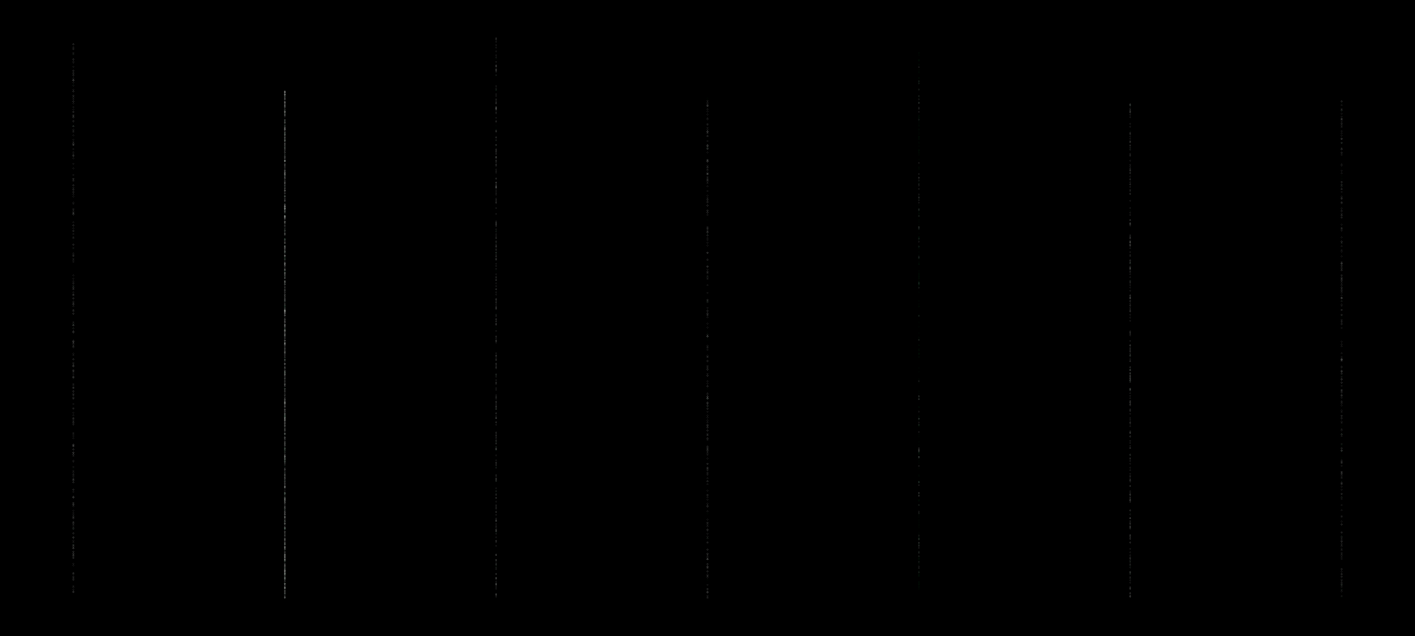

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,8))
ratio = 0.25
nsamples = int(result_df.shape[0] * ratio)
print(f"Plot using {nsamples:,d} samples ({ratio} of total)")
df_to_plot = result_df.sample(nsamples)
ax.scatter(
    df_to_plot.cat_taxonomy, df_to_plot.read_position,
    s=0.1,
    c=df_to_plot.loc[:, 'cov'], alpha=0.1, cmap='Greens',
)
ax.axis('off')
plt.show()

Plot using 2,860 samples (0.25 of total)


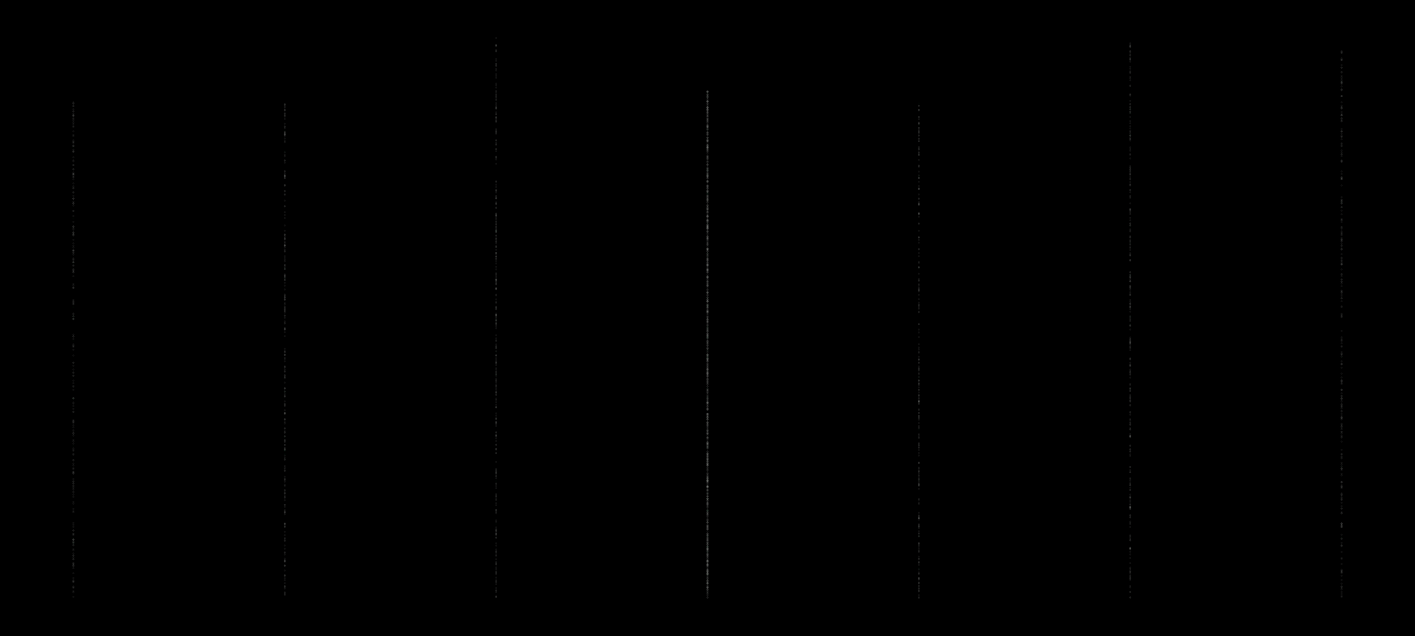

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,8))
ratio = 0.25
nsamples = int(result_df.shape[0] * ratio)
print(f"Plot using {nsamples:,d} samples ({ratio} of total)")
df_to_plot = result_df.sample(nsamples)
ax.scatter(
    df_to_plot.cat_taxonomy, df_to_plot.read_position,
    s=0.1,
    c=df_to_plot.loc[:, 'mers'], alpha=0.1, cmap='Greens',
)
ax.axis('off')
plt.show()

Plot using 2,860 samples (0.25 of total)


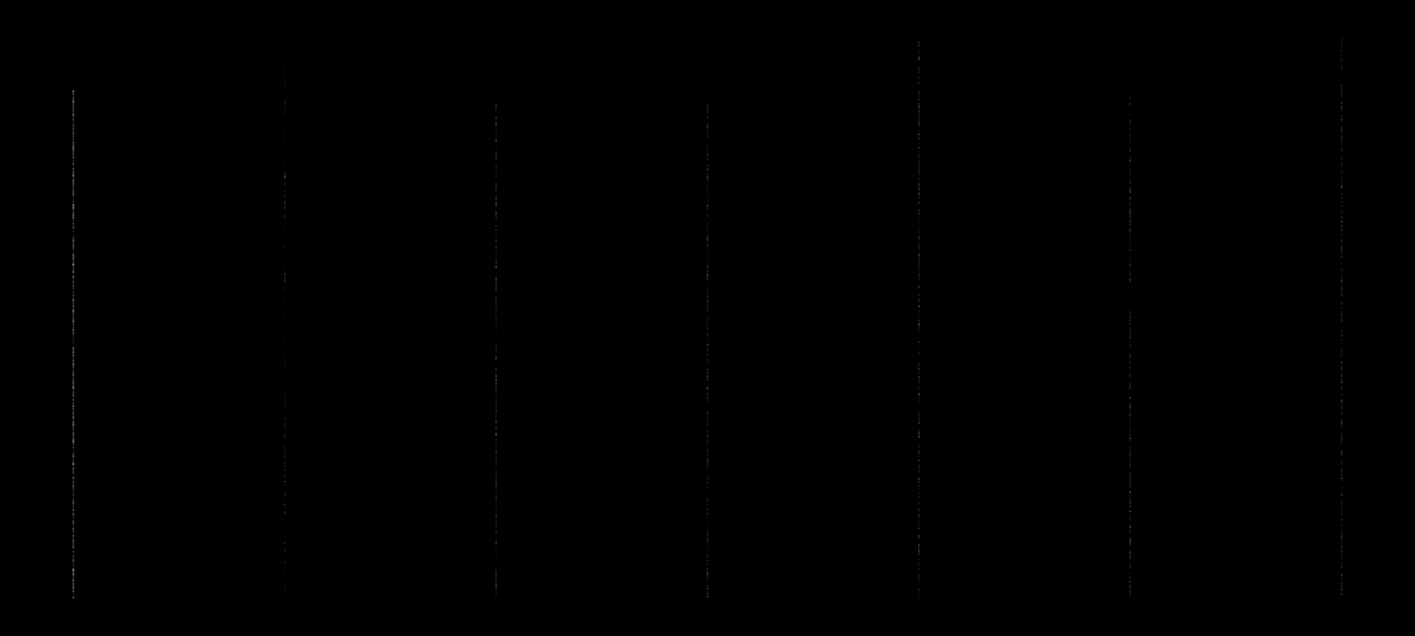

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,8))
ratio = 0.25
nsamples = int(result_df.shape[0] * ratio)
print(f"Plot using {nsamples:,d} samples ({ratio} of total)")
df_to_plot = result_df.sample(nsamples)
ax.scatter(
    df_to_plot.cat_taxonomy, df_to_plot.read_position,
    s=0.1,
    c=df_to_plot.loc[:, 'sars'], alpha=0.1, cmap='Greens',
)
ax.axis('off')
plt.show()

Position does not seem to have an obvious impact on whether the prediction is correct or not.

Taxonomy ID has a better predictive value

# Others